# Sign Language Recognition Model Training

This notebook trains a MobileNetV2 + LSTM model for real-time sign language recognition.

## Features:
- MobileNetV2 for spatial feature extraction
- LSTM for temporal sequence modeling
- Data augmentation for better generalization
- Model checkpointing and early stopping
- Comprehensive evaluation metrics

## 1. Import Libraries

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add project root to path
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

from src.data.data_loader import SignLanguageDataLoader
from src.models.sign_language_model import SignLanguageModel

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.15.0
GPU Available: []


## 2. Configuration

In [2]:
# Paths
DATASET_PATH = 'isl_dataset'
MODEL_SAVE_PATH = 'models/sign_language_model.h5'

# Training parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

# Model parameters
USE_SEQUENCE_MODEL = False  # Set to True for LSTM model, False for simple CNN
SEQUENCE_LENGTH = 30  # Only used if USE_SEQUENCE_MODEL is True

# Create models directory
os.makedirs('models', exist_ok=True)
os.makedirs('logs', exist_ok=True)

print("Configuration set!")

Configuration set!


## 3. Load Dataset

In [3]:
# Initialize data loader
data_loader = SignLanguageDataLoader(
    dataset_path=DATASET_PATH,
    image_size=IMAGE_SIZE,
    use_landmarks=False
)

# Create data generators
train_gen, val_gen, test_gen = data_loader.create_data_generators(
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    augment=True
)

# Get class information
class_names = data_loader.get_class_names()
num_classes = data_loader.get_num_classes()

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"\nTraining samples: {train_gen.n}")
print(f"Validation samples: {val_gen.n}")
print(f"Test samples: {test_gen.n}")

2026-01-18 09:51:48 - src.data.data_loader - INFO - DataLoader initialized with dataset path: isl_dataset
2026-01-18 09:51:48 - src.data.data_loader - INFO - Found 36 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
2026-01-18 09:51:48 - src.data.data_loader - INFO - Creating memory-efficient data generators


Found 23040 images belonging to 36 classes.
Found 5760 images belonging to 36 classes.
Found 7200 images belonging to 36 classes.


2026-01-18 09:51:50 - src.data.data_loader - INFO - Train samples: 23040
2026-01-18 09:51:50 - src.data.data_loader - INFO - Validation samples: 5760
2026-01-18 09:51:50 - src.data.data_loader - INFO - Test samples: 7200
2026-01-18 09:51:50 - src.data.data_loader - INFO - Classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35}



Number of classes: 36
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Training samples: 23040
Validation samples: 5760
Test samples: 7200


## 4. Visualize Sample Data

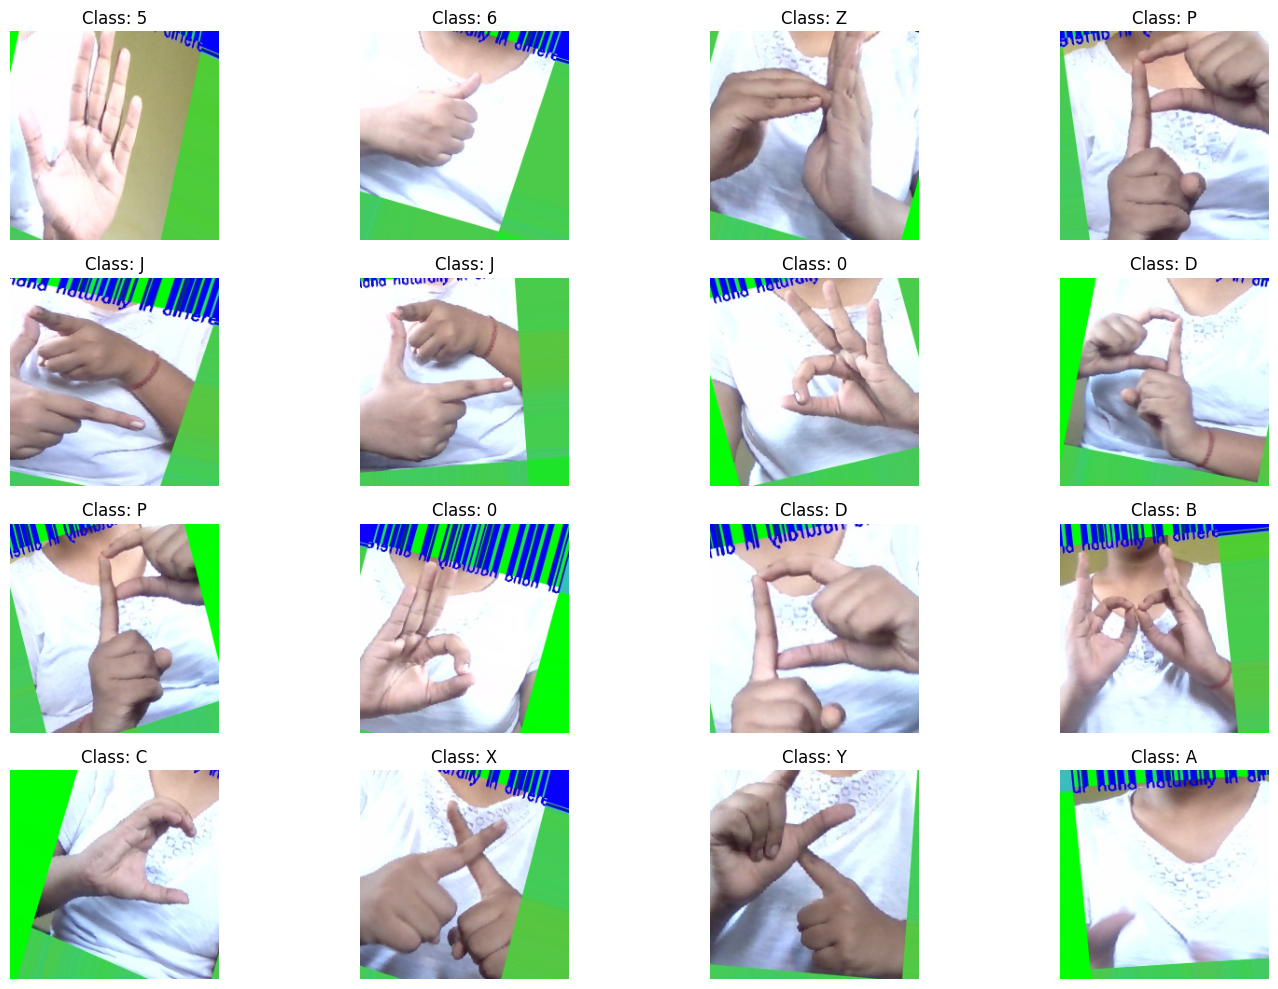

Sample images saved to logs/sample_images.png


In [4]:
# Get a batch of training data
sample_images, sample_labels = next(train_gen)

# Plot sample images
plt.figure(figsize=(15, 10))
for i in range(min(16, len(sample_images))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Class: {class_names[int(sample_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('logs/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample images saved to logs/sample_images.png")

## 5. Build Model

In [5]:
# Create model
sign_model = SignLanguageModel(
    num_classes=num_classes,
    image_size=IMAGE_SIZE,
    sequence_length=SEQUENCE_LENGTH
)

# Build model
model = sign_model.build_model(use_sequence=USE_SEQUENCE_MODEL)

# Compile model
sign_model.compile_model(learning_rate=LEARNING_RATE)

# Print model summary
sign_model.summary()

2026-01-18 09:51:57 - src.models.sign_language_model - INFO - Initializing model for 36 classes
2026-01-18 09:51:57 - src.models.sign_language_model - INFO - Building simple CNN model


2026-01-18 09:52:02 - src.models.sign_language_model - INFO - Model built with 3,054,436 parameters
2026-01-18 09:52:02 - src.models.sign_language_model - INFO - Model compiled with adam optimizer (lr=0.001)


Model: "sign_language_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)         

## 6. Setup Callbacks

In [6]:
# Model checkpoint - save best model
checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]

print("Callbacks configured!")

Callbacks configured!


## 7. Train Model

In [7]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/10


720/720 [==============================] - ETA: 0s - loss: 0.8510 - accuracy: 0.7592
Epoch 1: val_accuracy improved from -inf to 0.97622, saving model to models\sign_language_model.h5


C:\Users\k bhavaniprasad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


720/720 [==============================] - 1515s 2s/step - loss: 0.8510 - accuracy: 0.7592 - val_loss: 0.0893 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 2/10
720/720 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.9190
Epoch 2: val_accuracy improved from 0.97622 to 0.98420, saving model to models\sign_language_model.h5
720/720 [==============================] - 1066s 1s/step - loss: 0.2541 - accuracy: 0.9190 - val_loss: 0.0525 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 3/10
720/720 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9369
Epoch 3: val_accuracy improved from 0.98420 to 0.98872, saving model to models\sign_language_model.h5
720/720 [==============================] - 1088s 2s/step - loss: 0.2043 - accuracy: 0.9369 - val_loss: 0.0363 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 4/10
720/720 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9464
Epoch 4: val_accuracy improved from 0.98872 to 0.98993, saving model t

## 8. Plot Training History

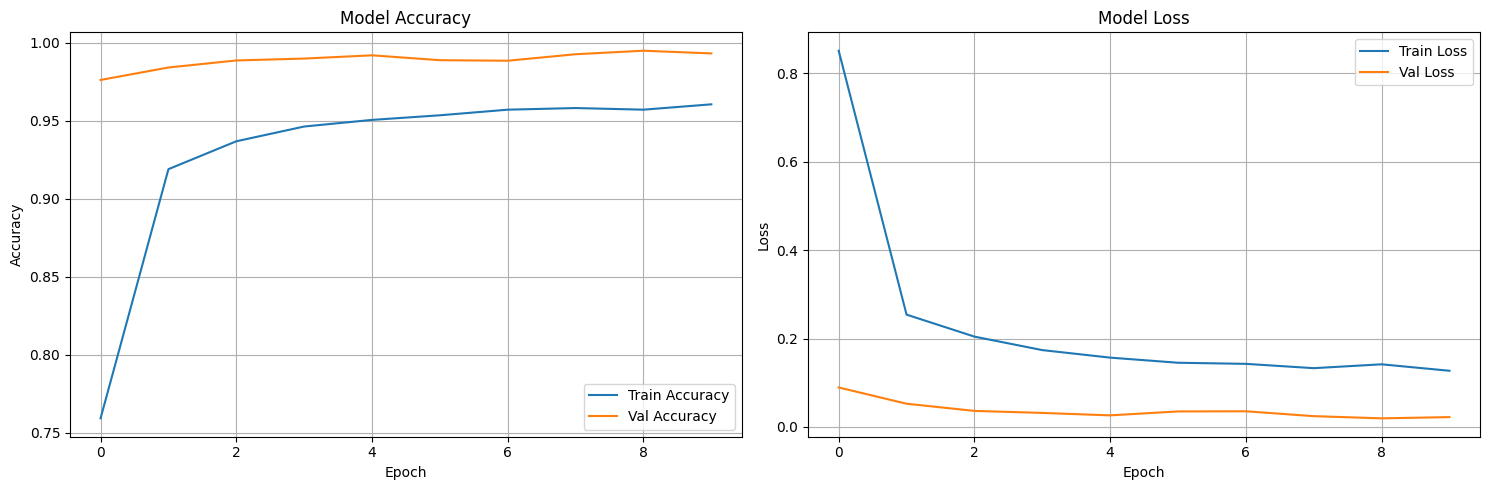

Training history saved to logs/training_history.png


In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('logs/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history saved to logs/training_history.png")

## 9. Evaluate Model

In [9]:
# Load best model
best_model = keras.models.load_model(MODEL_SAVE_PATH)

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_gen, verbose=1)

print(f"\n{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*50}")

225/225 [==============================] - 161s 711ms/step - loss: 0.0301 - accuracy: 0.9896

Test Loss: 0.0301
Test Accuracy: 0.9896 (98.96%)


## 10. Generate Predictions and Confusion Matrix

225/225 [==============================] - 79s 345ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.99      0.99      0.99       200
           2       1.00      1.00      1.00       200
           3       0.82      0.96      0.89       200
           4       0.96      0.78      0.86       200
           5       1.00      1.00      1.00       200
           6       1.00      1.00      1.00       200
           7       1.00      1.00      1.00       200
           8       1.00      1.00      1.00       200
           9       1.00      1.00      1.00       200
           A       1.00      1.00      1.00       200
           B       1.00      1.00      1.00       200
           C       1.00      0.95      0.97       200
           D       0.98      1.00      0.99       200
           E       1.00      1.00      1.00       200
           F       0.97      1.00      0.99       200

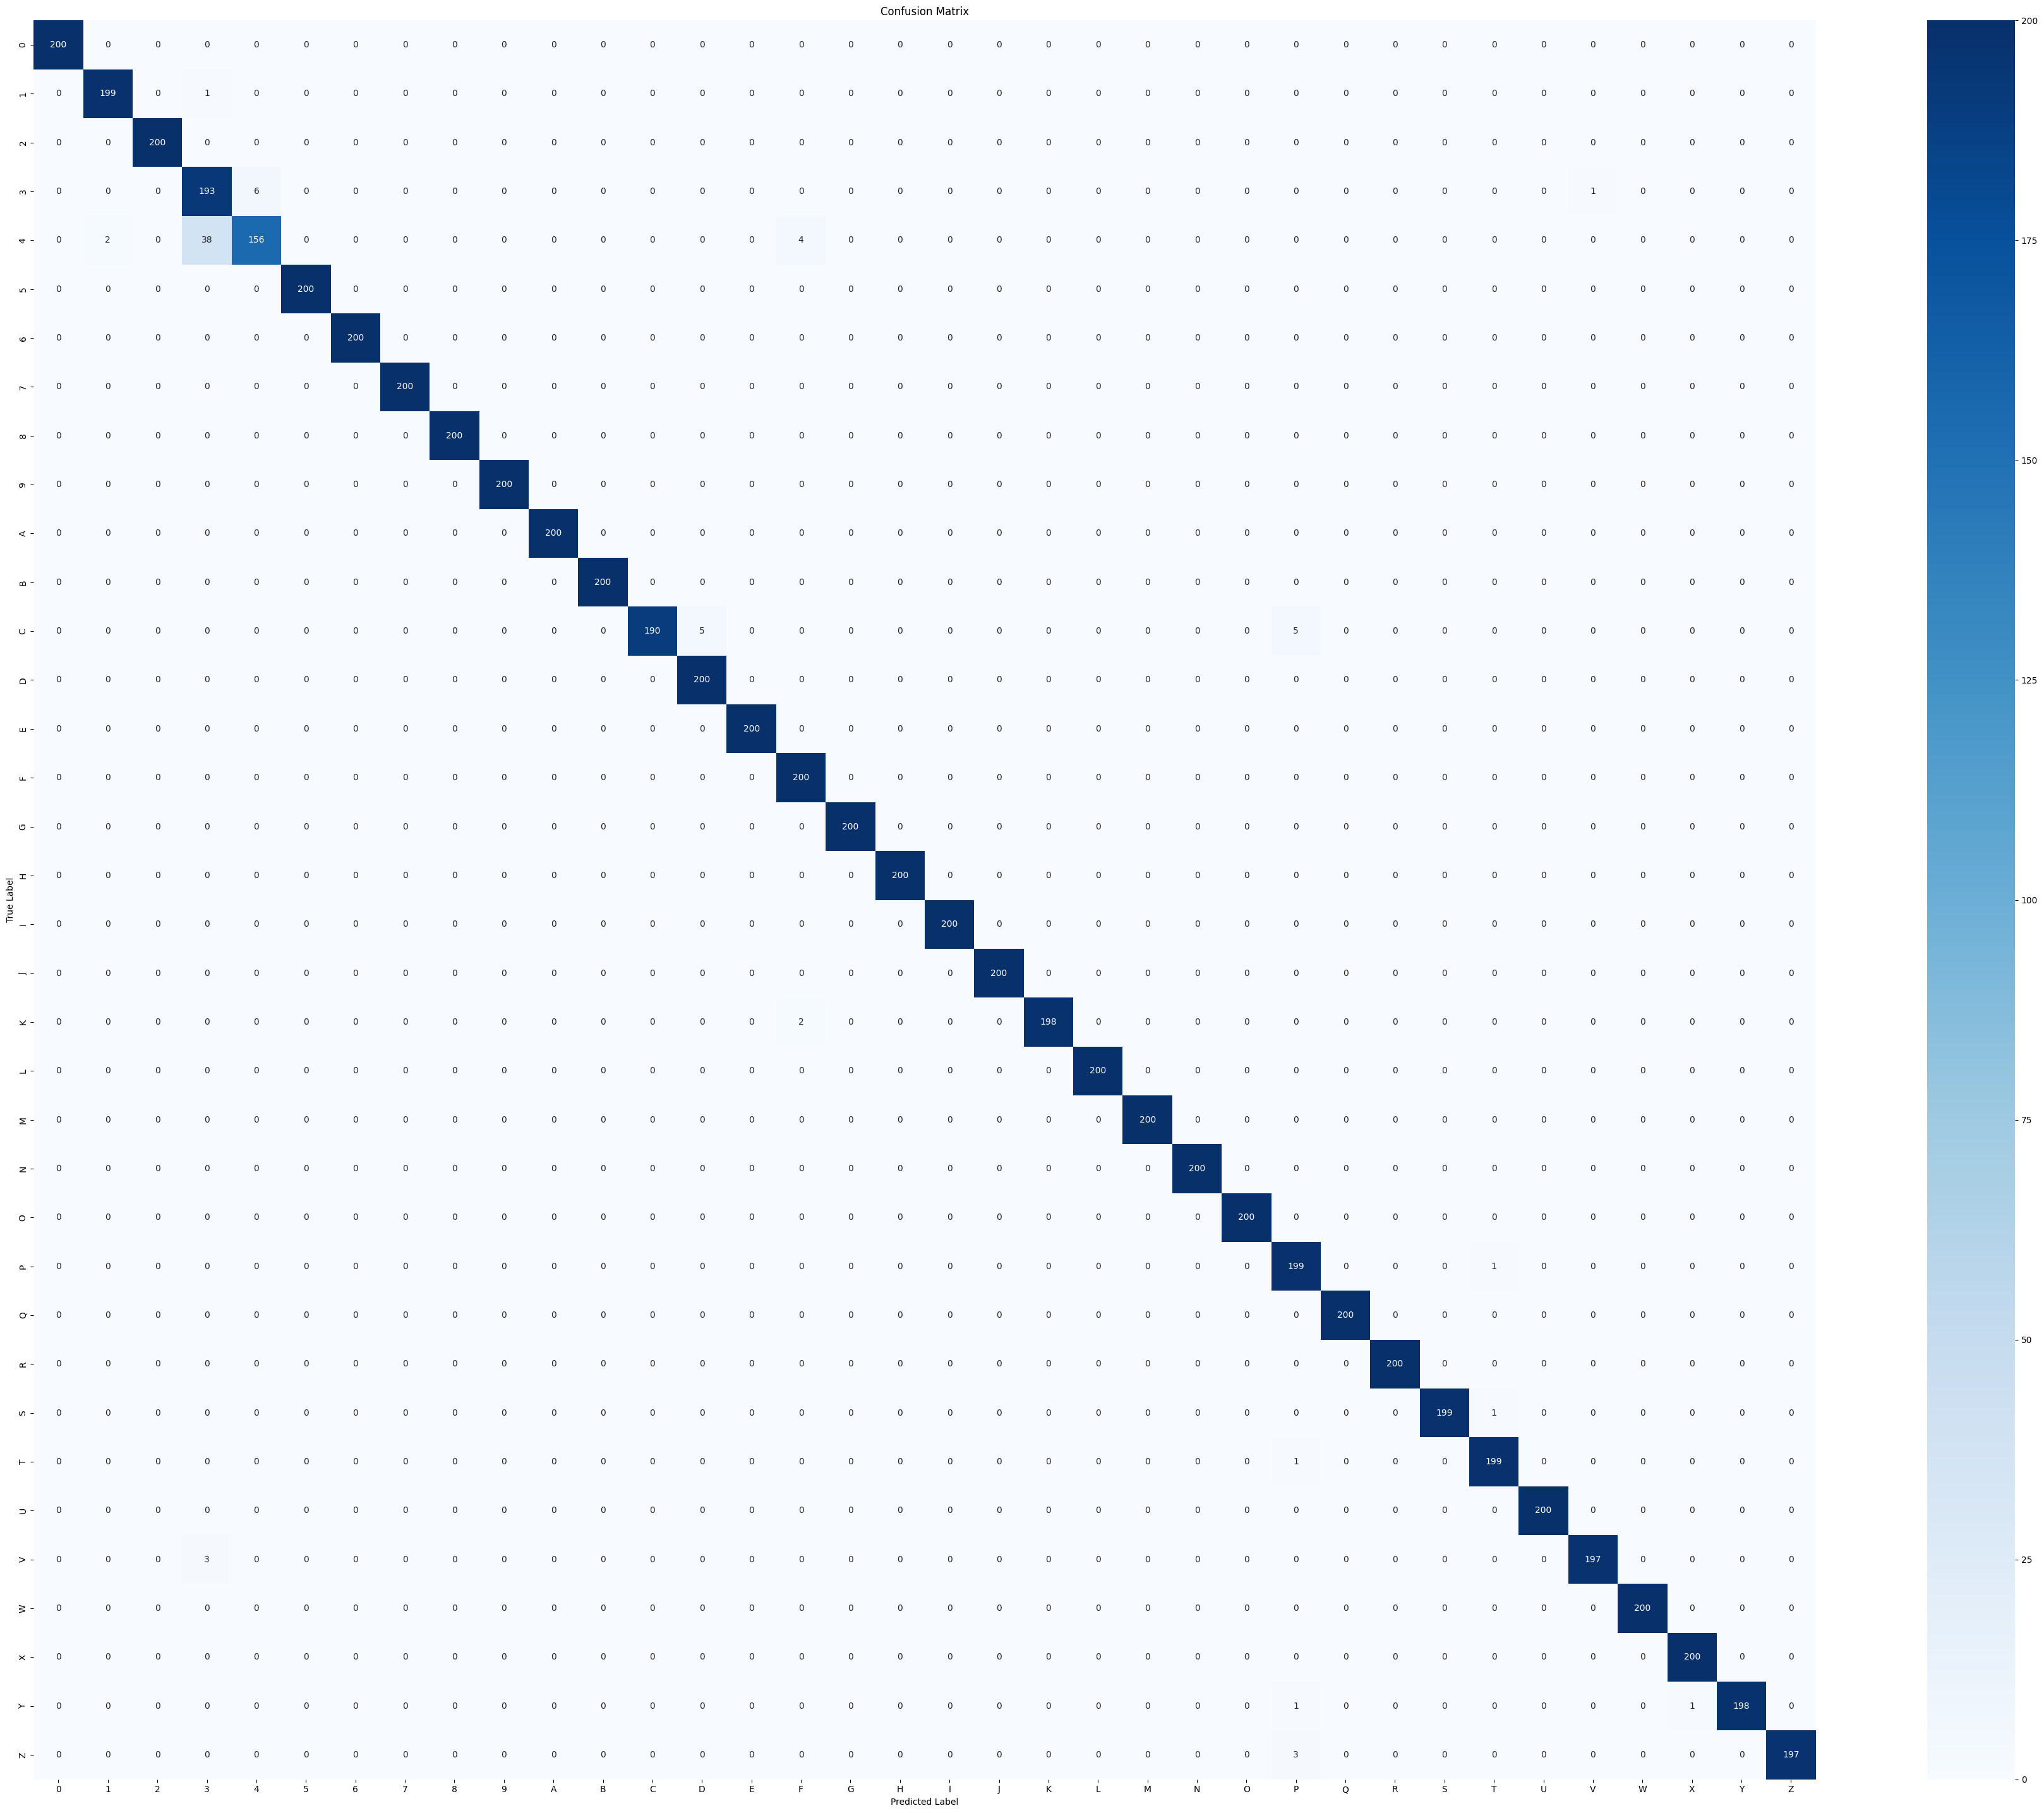


Confusion matrix saved to logs/confusion_matrix.png


In [10]:
# Get predictions
test_gen.reset()
predictions = best_model.predict(test_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_gen.classes

# Classification report
print("\nClassification Report:")
print("="*80)
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(max(10, num_classes), max(8, num_classes*0.8)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('logs/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to logs/confusion_matrix.png")

## 11. Test on Sample Images

1/1 [==============================] - 0s 440ms/step


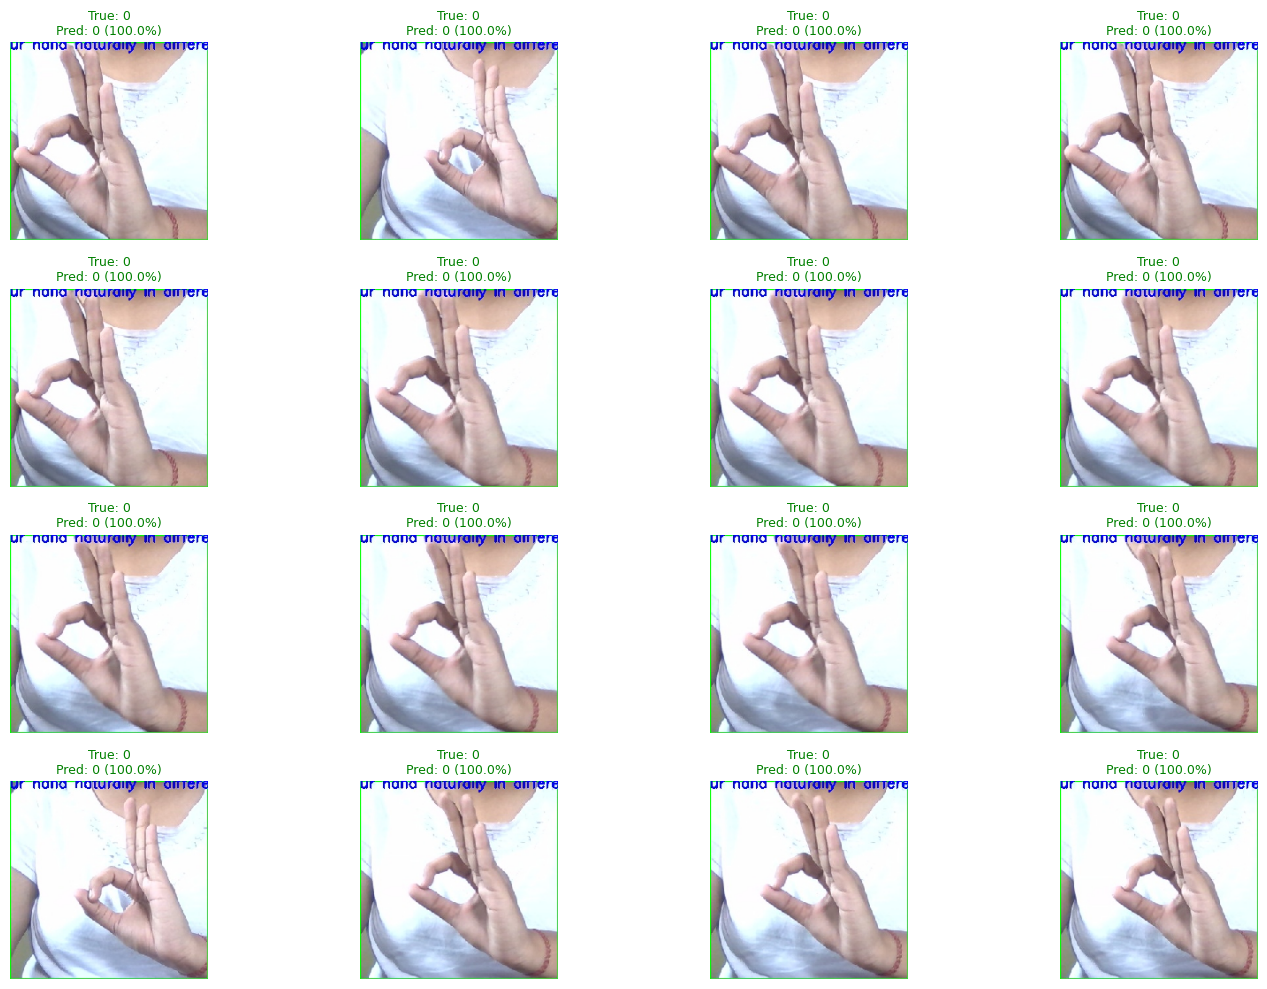

Test predictions saved to logs/test_predictions.png


In [12]:
# Get a batch of test images
test_gen.reset()
test_images, test_labels = next(test_gen)

# Make predictions
test_predictions = best_model.predict(test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Plot predictions
plt.figure(figsize=(15, 10))
for i in range(min(16, len(test_images))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i])
    
    # Convert labels to integers before using as indices
    true_label = class_names[int(test_labels[i])]
    pred_label = class_names[test_pred_classes[i]]
    confidence = test_predictions[i][test_pred_classes[i]] * 100
    
    color = 'green' if test_labels[i] == test_pred_classes[i] else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", 
              color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.savefig('logs/test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Test predictions saved to logs/test_predictions.png")

## 12. Save Model Information

In [13]:
# Save class names
import json

model_info = {
    'num_classes': num_classes,
    'class_names': class_names,
    'image_size': IMAGE_SIZE,
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'model_type': 'sequence' if USE_SEQUENCE_MODEL else 'simple',
    'sequence_length': SEQUENCE_LENGTH if USE_SEQUENCE_MODEL else None
}

with open('models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("Model information saved to models/model_info.json")
print("\nModel training complete!")
print(f"Model saved to: {MODEL_SAVE_PATH}")

Model information saved to models/model_info.json

Model training complete!
Model saved to: models/sign_language_model.h5


## Summary

The model has been successfully trained and saved. You can now use this model for real-time sign language recognition.

### Files Generated:
- `models/sign_language_model.h5` - Trained model
- `models/model_info.json` - Model metadata
- `logs/training_history.png` - Training curves
- `logs/confusion_matrix.png` - Confusion matrix
- `logs/test_predictions.png` - Sample predictions

### Next Steps:
1. Use the model in the real-time recognition system
2. Test with webcam input
3. Fine-tune if needed